In [ ]:
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MLRG/mean_tpm.csv", index_col=0)

In [ ]:
def normalize_group(group):
    scaler = StandardScaler()
    group['normalized_tpm'] = scaler.fit_transform(group[['mean_tpm']])
    return group

# df['mean_tpm'] = np.log1p(df['mean_tpm'])
df = df.groupby('species').apply(normalize_group)
df['mean_tpm'] = df['normalized_tpm']
df = df.reset_index(drop=True)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DNA_ResNet18(nn.Module):
    def __init__(self, num_species, num_stress_conditions, max_length=203):
        super(DNA_ResNet18, self).__init__()
        self.max_length = max_length

        # Load the pre-trained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=True)

        # Modify the first convolutional layer to accept 4-channel input
        self.resnet18.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Modify the fully connected layer to match the new input size
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()  # Remove the final fully connected layer

        # Fully connected layers for species and stress conditions
        self.fc_species = nn.Linear(num_species, 16)
        self.fc_stress = nn.Linear(num_stress_conditions, 16)

        # Final fully connected layer for combined features
        self.fc_final = nn.Linear(num_ftrs + 16 * 2, 1)

    def forward(self, x, species, stress):
        # Reshape input x to be [batch_size, 4, 1, max_length] for 2D convolution
        x = x.unsqueeze(2)  # [batch_size, 4, 1, max_length]

        # Pass the DNA sequence through ResNet18
        x = self.resnet18(x)

        # Process species and stress conditions
        species = torch.relu(self.fc_species(species))
        stress = torch.relu(self.fc_stress(stress))

        # Concatenate all features
        x = torch.cat((x, species, stress), dim=1)

        # Final prediction
        x = self.fc_final(x)
        return x


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GroupShuffleSplit
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# One-hot encode species and stress_condition
enc_species = OneHotEncoder(sparse_output=False)
encoded_species = enc_species.fit_transform(df[['species']])

enc_stress = OneHotEncoder(sparse_output=False)
encoded_stress_condition = enc_stress.fit_transform(df[['stress_condition']])

# Function to one-hot encode DNA sequence
def one_hot_encode_sequence(sequence, max_length=200):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_encoded = np.zeros((max_length, 4))
    for i, nucleotide in enumerate(sequence[:max_length]):
        if nucleotide in mapping:
            one_hot_encoded[i, mapping[nucleotide]] = 1
    return one_hot_encoded

# Apply one-hot encoding to the DNA sequences
max_length = df['upstream200'].apply(len).max()
sequences = df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
sequences = np.array(sequences.tolist())

# Combine species and stress_condition into a single group column
df['group'] = df['species'].astype(str) + "_" + df['stress_condition'].astype(str)

# Stratified split using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['group']))

df_train_val = df.iloc[train_idx]
df_test = df.iloc[test_idx]

gss_val = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(gss_val.split(df_train_val, groups=df_train_val['group']))

df_train = df_train_val.iloc[train_idx]
df_val = df_train_val.iloc[val_idx]

# Convert to PyTorch tensors
def prepare_tensors(df):
    sequences = df['upstream200'].apply(lambda seq: one_hot_encode_sequence(seq, max_length=max_length))
    sequences = np.array(sequences.tolist())
    species = enc_species.transform(df[['species']])
    stress = enc_stress.transform(df[['stress_condition']])
    y = df['mean_tpm'].values

    sequence_tensor = torch.tensor(sequences, dtype=torch.float32).permute(0, 2, 1)
    species_tensor = torch.tensor(species, dtype=torch.float32)
    stress_tensor = torch.tensor(stress, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    return sequence_tensor, species_tensor, stress_tensor, y_tensor

sequence_tensor_train, species_tensor_train, stress_tensor_train, y_tensor_train = prepare_tensors(df_train)
sequence_tensor_val, species_tensor_val, stress_tensor_val, y_tensor_val = prepare_tensors(df_val)
sequence_tensor_test, species_tensor_test, stress_tensor_test, y_tensor_test = prepare_tensors(df_test)

# Create datasets
train_dataset = TensorDataset(sequence_tensor_train, species_tensor_train, stress_tensor_train, y_tensor_train)
val_dataset = TensorDataset(sequence_tensor_val, species_tensor_val, stress_tensor_val, y_tensor_val)
test_dataset = TensorDataset(sequence_tensor_test, species_tensor_test, stress_tensor_test, y_tensor_test)

# Create dataloaders
batch_size = 32  # 调整batch size以适应内存限制
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model definition (assuming DNA_ResNet18 is defined as in the previous response)
model = DNA_ResNet18(num_species=encoded_species.shape[1], num_stress_conditions=encoded_stress_condition.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for step, (seqs, species, stress, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(seqs, species, stress)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        step_loss = loss.item() * seqs.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{len(train_loader)}], Loss: {step_loss:.4f}')
        train_loss += step_loss

    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seqs, species, stress, targets in val_loader:
            outputs = model(seqs, species, stress)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * seqs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Step [1/20813], Loss: 8.2232
Epoch [1/10], Step [2/20813], Loss: 45.6740
Epoch [1/10], Step [3/20813], Loss: 37.5260
Epoch [1/10], Step [4/20813], Loss: 50.6268
Epoch [1/10], Step [5/20813], Loss: 149.8684
Epoch [1/10], Step [6/20813], Loss: 46.7522
Epoch [1/10], Step [7/20813], Loss: 62.3894
Epoch [1/10], Step [8/20813], Loss: 58.7674
Epoch [1/10], Step [9/20813], Loss: 64.3099
Epoch [1/10], Step [10/20813], Loss: 134.4101
Epoch [1/10], Step [11/20813], Loss: 62.9347
Epoch [1/10], Step [12/20813], Loss: 68.3382
Epoch [1/10], Step [13/20813], Loss: 19.6406
Epoch [1/10], Step [14/20813], Loss: 49.6448
Epoch [1/10], Step [15/20813], Loss: 34.5235
Epoch [1/10], Step [16/20813], Loss: 36.2852
Epoch [1/10], Step [17/20813], Loss: 40.6300
Epoch [1/10], Step [18/20813], Loss: 17.8039
Epoch [1/10], Step [19/20813], Loss: 15.7118
Epoch [1/10], Step [20/20813], Loss: 17.4826
Epoch [1/10], Step [21/20813], Loss: 9.5330
Epoch [1/10], Step [22/20813], Loss: 30.5875
Epoch [1/10], Step 

KeyboardInterrupt: 

In [ ]:
# Create dataloaders
batch_size = 8192  # 调整batch size以适应内存限制
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model definition (assuming DNA_ResNet18 is defined as in the previous response)
model = DNA_ResNet18(num_species=encoded_species.shape[1], num_stress_conditions=encoded_stress_condition.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for step, (seqs, species, stress, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(seqs, species, stress)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        step_loss = loss.item() * seqs.size(0)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{len(train_loader)}], Loss: {step_loss:.4f}')
        train_loss += step_loss

    train_loss /= len(train_loader.dataset)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for seqs, species, stress, targets in val_loader:
            outputs = model(seqs, species, stress)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * seqs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch [1/10], Step [1/82], Loss: 19266.9121
Epoch [1/10], Step [2/82], Loss: 1259467.5000
Epoch [1/10], Step [3/82], Loss: 495840.6875
Epoch [1/10], Step [4/82], Loss: 130483.0781
Epoch [1/10], Step [5/82], Loss: 32357.8105
Epoch [1/10], Step [6/82], Loss: 6682.7510
Epoch [1/10], Step [7/82], Loss: 22543.4180
Epoch [1/10], Step [8/82], Loss: 46855.2969
Epoch [1/10], Step [9/82], Loss: 68046.6641
Epoch [1/10], Step [10/82], Loss: 85345.4062
Epoch [1/10], Step [11/82], Loss: 50687.5703
Epoch [1/10], Step [12/82], Loss: 25244.1426
Epoch [1/10], Step [13/82], Loss: 49395.5938
Epoch [1/10], Step [14/82], Loss: 15659.5176
Epoch [1/10], Step [15/82], Loss: 10764.8975
Epoch [1/10], Step [16/82], Loss: 11339.5977
Epoch [1/10], Step [17/82], Loss: 23517.4746
Epoch [1/10], Step [18/82], Loss: 8196.1660
Epoch [1/10], Step [19/82], Loss: 11071.3672
Epoch [1/10], Step [20/82], Loss: 10048.5293
Epoch [1/10], Step [21/82], Loss: 9323.2607
Epoch [1/10], Step [22/82], Loss: 5472.7295
Epoch [1/10], Step 

KeyboardInterrupt: 

In [ ]:
model.eval()
test_loss = 0.0
predictions, ground_truth = [], []
with torch.no_grad():
    for seqs, species, stress, targets in test_loader:
        outputs = model(seqs, species, stress)
        predictions.append(outputs)
        ground_truth.append(targets)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * seqs.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.0364


In [ ]:
predictions = torch.cat(predictions, axis=0)
ground_truth = torch.cat(ground_truth, axis=0)
output_df = pd.DataFrame({'actual': ground_truth.flatten(), 'predicted': predictions.flatten()})

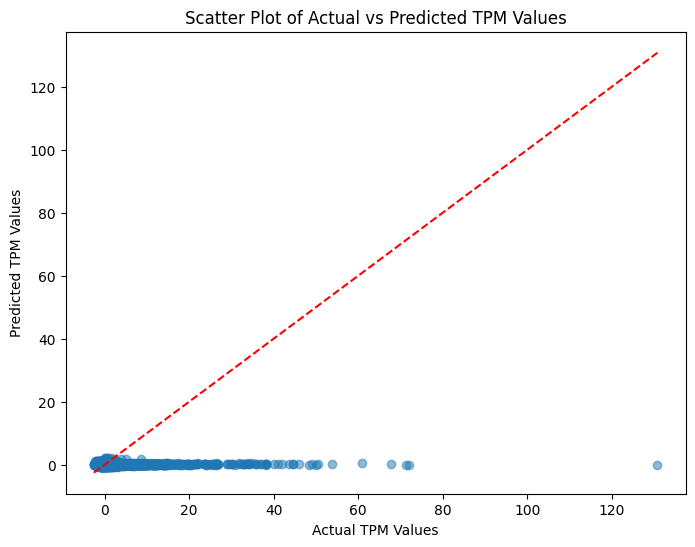

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(output_df['actual'], output_df['predicted'], alpha=0.5)
plt.plot([output_df['actual'].min(), output_df['actual'].max()], [output_df['actual'].min(), output_df['actual'].max()], 'r--')
plt.xlabel('Actual TPM Values')
plt.ylabel('Predicted TPM Values')
plt.title('Scatter Plot of Actual vs Predicted TPM Values')
plt.show()

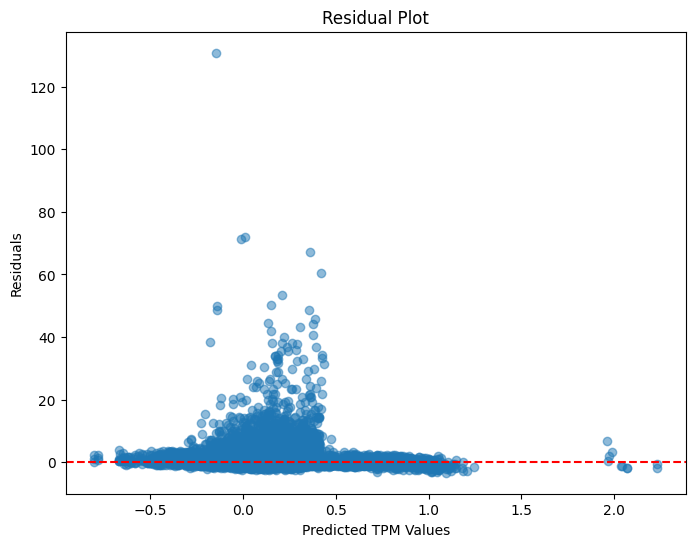

In [ ]:
output_df['residuals'] = output_df['actual'] - output_df['predicted']

plt.figure(figsize=(8, 6))
plt.scatter(output_df['predicted'], output_df['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted TPM Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()